In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

random_state = 42

In [2]:
def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

subjects_bak_spec = read_dataset("../../../../../data/datasets/filtered/subjects_bak_spec_filtered_if.csv")
subjects_magistr = read_dataset("../../../../../data/datasets/filtered/subjects_magistr_filtered_if.csv")

In [3]:
X_s_bak_spec = subjects_bak_spec.drop(columns=["Таргет"])
y_s_bak_spec = subjects_bak_spec["Таргет"]

X_train_s_bak_spec, X_test_s_bak_spec, y_train_s_bak_spec, y_test_s_bak_spec = train_test_split(
    X_s_bak_spec,
    y_s_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_s_magistr = subjects_magistr.drop(columns=["Таргет"])
y_s_magistr = subjects_magistr["Таргет"]

X_train_s_magistr, X_test_s_magistr, y_train_s_magistr, y_test_s_magistr = train_test_split(
    X_s_magistr,
    y_s_magistr,
    test_size=0.2,
    random_state=random_state
)

Автоматически вычисленные веса классов: {0: np.float64(0.5852534562211982), 1: np.float64(3.4324324324324325)}
Лучший порог: 0.687, F1 для класса 1: 0.500

Отчёт классификации с оптимальным порогом:

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       110
           1       0.50      0.50      0.50        18

    accuracy                           0.86       128
   macro avg       0.71      0.71      0.71       128
weighted avg       0.86      0.86      0.86       128



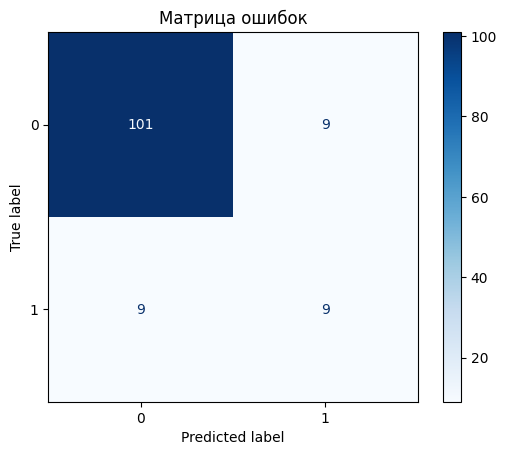

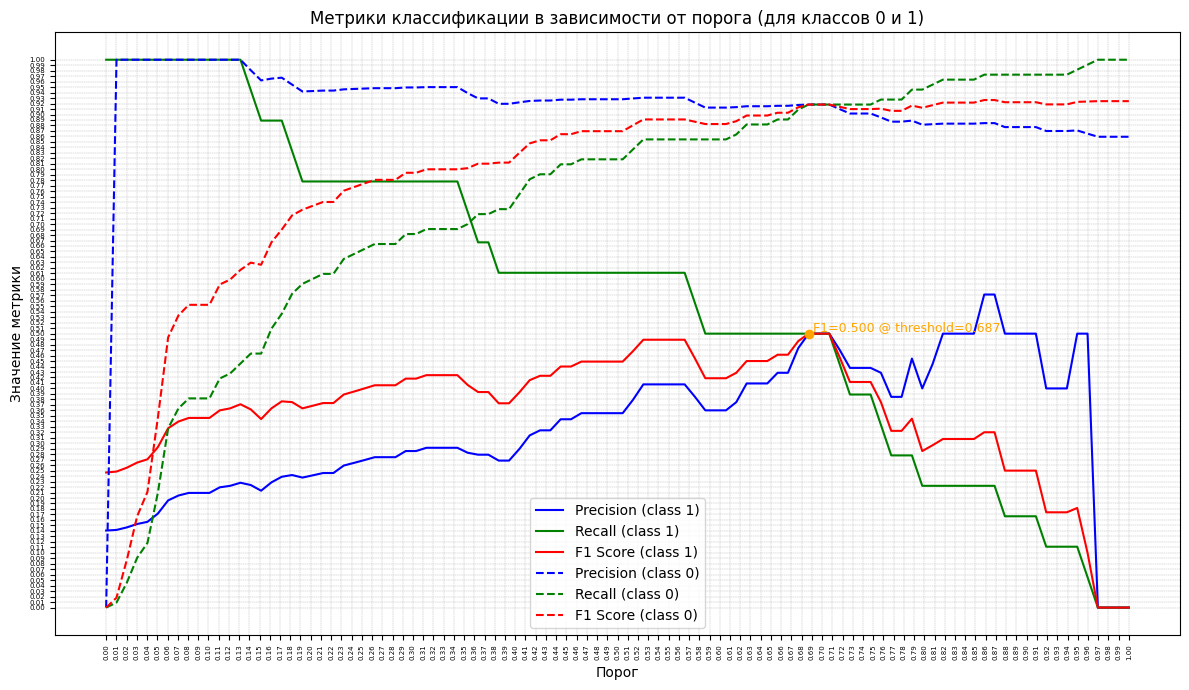

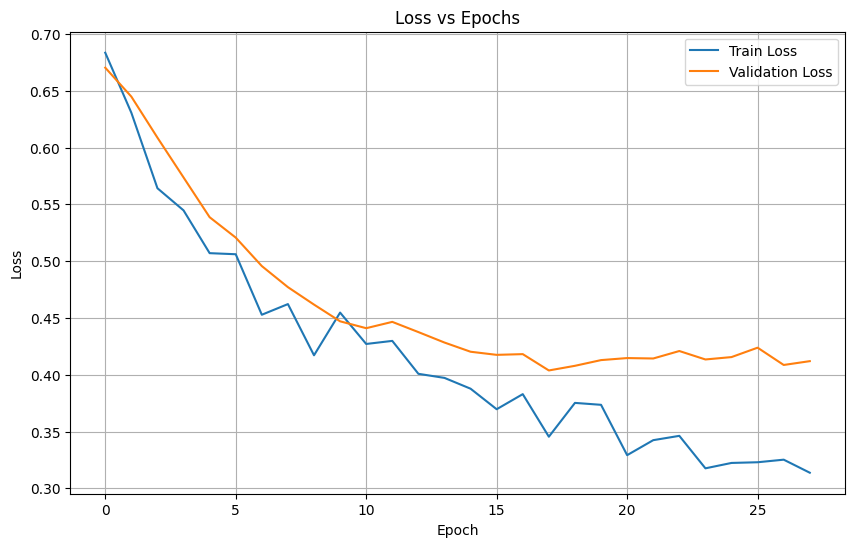

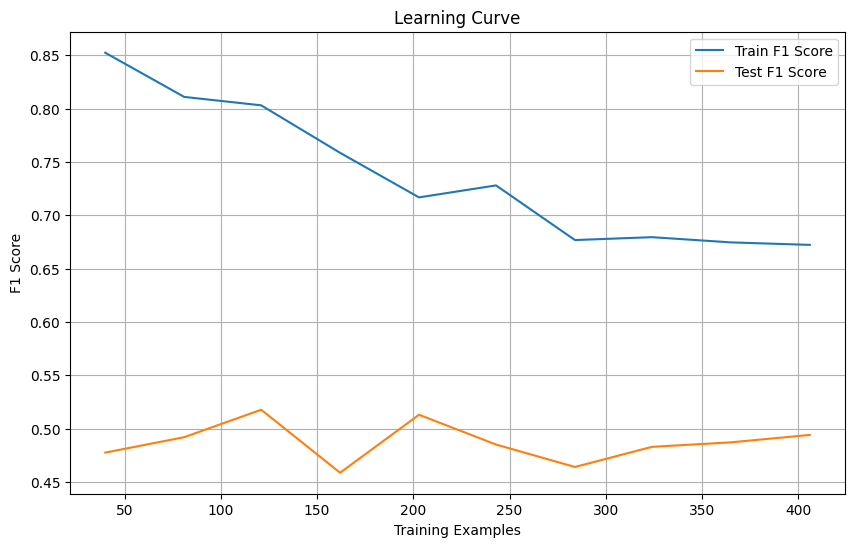

In [4]:
'''-----------------------------------------------------------------------------------------------------
                                        ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК
-----------------------------------------------------------------------------------------------------'''

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

'''-----------------------------------------------------------------------------------------------------
                                          НАСТРОЙКА RANDOM STATE
-----------------------------------------------------------------------------------------------------'''

import random
import os

random_state = 42

np.random.seed(random_state)
random.seed(random_state)
tf.random.set_seed(random_state)

from tensorflow.keras.utils import set_random_seed

set_random_seed(random_state)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

'''-----------------------------------------------------------------------------------------------------
                                            ПОДГОТОВКА ПАЙПЛАЙНА
-----------------------------------------------------------------------------------------------------'''

scaler = StandardScaler()
X_train_scaled_s_magistr = scaler.fit_transform(X_train_s_magistr)
X_test_scaled_s_magistr = scaler.transform(X_test_s_magistr)

def build_model():
    model = Sequential([
        tf.keras.Input(shape=(X_train_scaled_s_magistr.shape[1],)),
        Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
        tf.keras.layers.Dropout(0.3),
        Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
        Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state))
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()

'''-----------------------------------------------------------------------------------------------------
                                                ОБУЧЕНИЕ МОДЕЛИ
-----------------------------------------------------------------------------------------------------'''

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_s_magistr), y=y_train_s_magistr)
class_weight_dict = dict(enumerate(class_weights))

print("Автоматически вычисленные веса классов:", class_weight_dict)

history = model.fit(
    X_train_scaled_s_magistr,
    y_train_s_magistr,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=0,
    shuffle=True
)

model.save('../../../../../data/models/final/filtered/nn_model_s_magistr_if.keras')

y_probs = model.predict(X_test_scaled_s_magistr, verbose=0).flatten()

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))

best_idx = np.argmax(f1_scores_1)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores_1[best_idx]

print(f"Лучший порог: {best_threshold:.3f}, F1 для класса 1: {best_f1:.3f}")

y_pred_s_magistr = (y_probs >= best_threshold).astype(int)

print("\nОтчёт классификации с оптимальным порогом:\n")
print(classification_report(y_test_s_magistr, y_pred_s_magistr))

cm = confusion_matrix(y_test_s_magistr, y_pred_s_magistr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig('nn/s_magistr/confusion_matrix_nn.png')
plt.show()

save_path = 'nn/s_magistr'
os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(12, 7))
plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.scatter(best_threshold, best_f1, color='orange', zorder=5)
plt.text(best_threshold, best_f1,
         f' F1={best_f1:.3f} @ threshold={best_threshold:.3f}',
         fontsize=9, color='orange', verticalalignment='bottom')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_nn.png'), dpi=300)
plt.show()

'''-----------------------------------------------------------------------------------------------------
                              ВЫВОД ЗАВИСИМОСТИ F1 ОТ ЭПОХ ОБУЧЕНИЯ
-----------------------------------------------------------------------------------------------------'''

history_df = pd.DataFrame(history.history)
history_df['epoch'] = range(len(history_df))

plt.figure(figsize=(10, 6))
sns.lineplot(data=history_df, x='epoch', y='loss', label='Train Loss')
sns.lineplot(data=history_df, x='epoch', y='val_loss', label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('nn/s_magistr/loss_vs_epochs_nn.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                           ВЫВОД КРИВОЙ ОБУЧЕНИЯ
-----------------------------------------------------------------------------------------------------'''

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model_func, epochs=10, batch_size=32, verbose=0, class_weight=None, random_state=42):
        self.model_func = model_func
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.class_weight = class_weight
        self.random_state = random_state

    def fit(self, X, y):
        tf.random.set_seed(self.random_state)
        np.random.seed(self.random_state)
        random.seed(self.random_state)

        self.model_ = self.model_func()
        self.model_.fit(X, y,
                        epochs=self.epochs,
                        batch_size=self.batch_size,
                        verbose=self.verbose,
                        class_weight=self.class_weight)
        return self

    def predict(self, X):
        return (self.model_.predict(X, verbose=0).flatten() > 0.5).astype(int)

    def predict_proba(self, X):
        probas = self.model_.predict(X, verbose=0).flatten()
        return np.vstack([1 - probas, probas]).T

final_epochs = early_stop.stopped_epoch + 1 if hasattr(early_stop, 'stopped_epoch') and early_stop.stopped_epoch else 10

wrapped_model = KerasClassifierWrapper(
    build_model,
    epochs=final_epochs,
    batch_size=32,
    class_weight=class_weight_dict,
    random_state=random_state
)

train_sizes, train_scores, test_scores = learning_curve(
    wrapped_model,
    X_train_scaled_s_magistr,
    y_train_s_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=make_scorer(f1_score, pos_label=1),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('nn/s_magistr/learning_curve_nn.png')
plt.show()

Автоматически вычисленные веса классов: {0: np.float64(0.6005888125613347), 1: np.float64(2.9853658536585366)}
Лучший порог: 0.525, F1 для класса 1: 0.622

Отчёт классификации с оптимальным порогом:

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       248
           1       0.51      0.79      0.62        58

    accuracy                           0.82       306
   macro avg       0.73      0.81      0.75       306
weighted avg       0.86      0.82      0.83       306



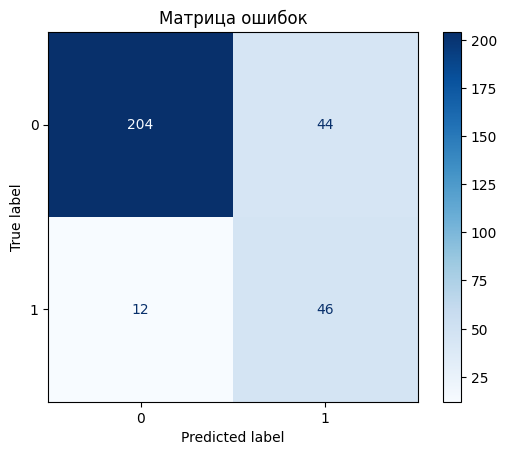

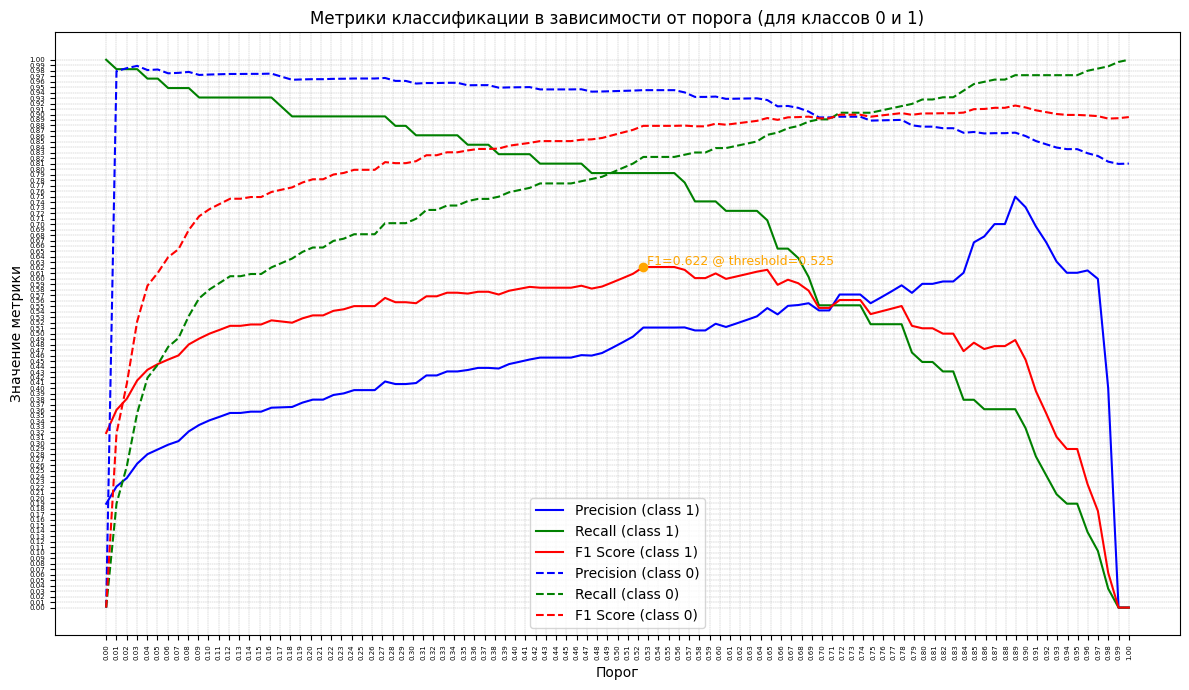

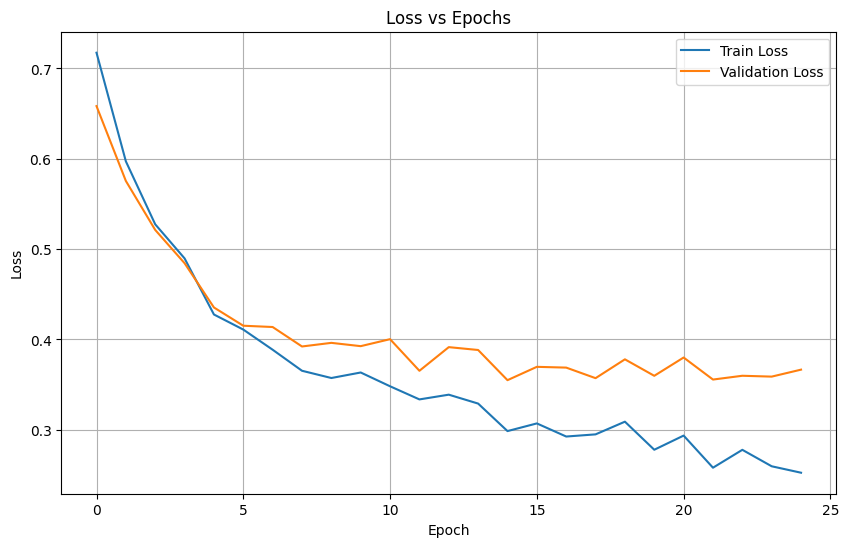

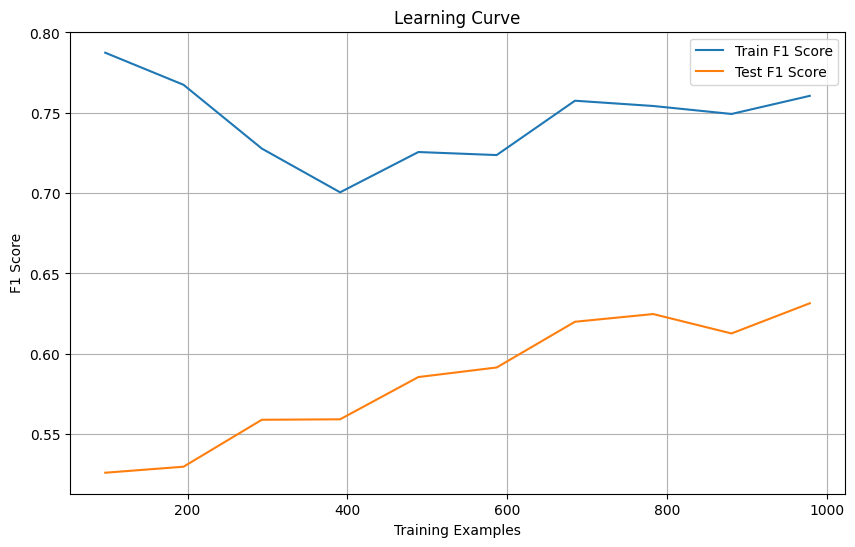

In [5]:
'''-----------------------------------------------------------------------------------------------------
                                        ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК
-----------------------------------------------------------------------------------------------------'''

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

'''-----------------------------------------------------------------------------------------------------
                                          НАСТРОЙКА RANDOM STATE
-----------------------------------------------------------------------------------------------------'''

import random
import os

random_state = 42

np.random.seed(random_state)
random.seed(random_state)
tf.random.set_seed(random_state)

from tensorflow.keras.utils import set_random_seed

set_random_seed(random_state)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

'''-----------------------------------------------------------------------------------------------------
                                            ПОДГОТОВКА ПАЙПЛАЙНА
-----------------------------------------------------------------------------------------------------'''

scaler = StandardScaler()
X_train_scaled_s_bak_spec = scaler.fit_transform(X_train_s_bak_spec)
X_test_scaled_s_bak_spec = scaler.transform(X_test_s_bak_spec)

def build_model():
    model = Sequential([
        tf.keras.Input(shape=(X_train_scaled_s_bak_spec.shape[1],)),
        Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
        tf.keras.layers.Dropout(0.3),
        Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state)),
        Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state))
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()

'''-----------------------------------------------------------------------------------------------------
                                                ОБУЧЕНИЕ МОДЕЛИ
-----------------------------------------------------------------------------------------------------'''

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_s_bak_spec), y=y_train_s_bak_spec)
class_weight_dict = dict(enumerate(class_weights))

print("Автоматически вычисленные веса классов:", class_weight_dict)

history = model.fit(
    X_train_scaled_s_bak_spec,
    y_train_s_bak_spec,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=0,
    shuffle=True
)

model.save('../../../../../data/models/final/filtered/nn_model_s_bak_spec_if.keras')

y_probs = model.predict(X_test_scaled_s_bak_spec, verbose=0).flatten()

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

best_idx = np.argmax(f1_scores_1)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores_1[best_idx]

print(f"Лучший порог: {best_threshold:.3f}, F1 для класса 1: {best_f1:.3f}")

y_pred_s_bak_spec = (y_probs >= best_threshold).astype(int)

print("\nОтчёт классификации с оптимальным порогом:\n")
print(classification_report(y_test_s_bak_spec, y_pred_s_bak_spec))

cm = confusion_matrix(y_test_s_bak_spec, y_pred_s_bak_spec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig('nn/s_bak_spec/confusion_matrix_nn.png')
plt.show()

save_path = 'nn/s_bak_spec'
os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(12, 7))
plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.scatter(best_threshold, best_f1, color='orange', zorder=5)
plt.text(best_threshold, best_f1,
         f' F1={best_f1:.3f} @ threshold={best_threshold:.3f}',
         fontsize=9, color='orange', verticalalignment='bottom')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_nn.png'), dpi=300)
plt.show()

'''-----------------------------------------------------------------------------------------------------
                              ВЫВОД ЗАВИСИМОСТИ F1 ОТ ЭПОХ ОБУЧЕНИЯ
-----------------------------------------------------------------------------------------------------'''

history_df = pd.DataFrame(history.history)
history_df['epoch'] = range(len(history_df))

plt.figure(figsize=(10, 6))
sns.lineplot(data=history_df, x='epoch', y='loss', label='Train Loss')
sns.lineplot(data=history_df, x='epoch', y='val_loss', label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('nn/s_bak_spec/loss_vs_epochs_nn.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                           ВЫВОД КРИВОЙ ОБУЧЕНИЯ
-----------------------------------------------------------------------------------------------------'''

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model_func, epochs=10, batch_size=32, verbose=0, class_weight=None, random_state=42):
        self.model_func = model_func
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.class_weight = class_weight
        self.random_state = random_state

    def fit(self, X, y):
        tf.random.set_seed(self.random_state)
        np.random.seed(self.random_state)
        random.seed(self.random_state)

        self.model_ = self.model_func()
        self.model_.fit(X, y,
                        epochs=self.epochs,
                        batch_size=self.batch_size,
                        verbose=self.verbose,
                        class_weight=self.class_weight)
        return self

    def predict(self, X):
        return (self.model_.predict(X, verbose=0).flatten() > 0.5).astype(int)

    def predict_proba(self, X):
        probas = self.model_.predict(X, verbose=0).flatten()
        return np.vstack([1 - probas, probas]).T

final_epochs = early_stop.stopped_epoch + 1 if hasattr(early_stop, 'stopped_epoch') and early_stop.stopped_epoch else 10

wrapped_model = KerasClassifierWrapper(
    build_model,
    epochs=final_epochs,
    batch_size=32,
    class_weight=class_weight_dict,
    random_state=random_state
)

train_sizes, train_scores, test_scores = learning_curve(
    wrapped_model,
    X_train_scaled_s_bak_spec,
    y_train_s_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=make_scorer(f1_score, pos_label=1),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('nn/s_bak_spec/learning_curve_nn.png')
plt.show()